## Introduction
This experiment developed a system that is designed to facilitate communication between people who have vocal-auditory disability. The experiment has machine learning techniques to perform the due process of recognition of hand gestures of the Colombian sign language, recognizing the numbers from 0 to 5 and the vowels. 

This experiment works through 4 stages: taking photographs, pre-processing the photo, extracting the characteristics of the photo and finally performs the classification process for the identification of the gesture being carried out. 
The image is captured by any camera that has a good quality shot. Then move on to the next stage of pre-processing, where you want to clean the techniques to remove the shadow, the background and leave the image clean to perform the process of segmentation where the process of eliminating the noises that this pose takes place. 

At the stage of extraction of characteristics, it extracts the characteristics of the image that give us the mathematical methods like: Moments of Hu, ellipticals of Fourier, histograms oriented to gradients (HOG) and geometric characteristics. 
Finally, using the vector support machine classifier (SVM) you get the value of the sign, if it is a number or a vowel.

## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions perform pre-processing and extracting features ` Cv2` (OpenCV), ` Sklearn`, `scipy`, `skimage`. 
Use the `pyefd` library to get the Fourier ellipticals.
For the classification processes the library of `sklearn` was used.


In [3]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/kaggle"
# !kaggle datasets download -d evernext10/hand-gesture-of-the-colombian-sign-language
# !unzip '/content/kaggle/hand-gesture-of-the-colombian-sign-language.zip' -d '/content/kaggle/dataset'
# !rm -rf /content/kaggle/dataset/men/A

In [4]:
# %pip install pyefd

In [5]:
import os
import numpy as np
import cv2
from scipy import ndimage as ndi
import imageio
from os import walk
from pyefd import elliptic_fourier_descriptors
from skimage import feature
import pandas as pd
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,GridSearchCV  
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import collections
import joblib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
np.random.seed(42)


There is 0 csv file in the current version of the dataset:


The next hidden code cells define functions for plotting data. Click on the "Code" button in the published kernel to reveal the hidden code.

In [6]:
# !rm -rf /content/kaggle/dataset/dataset

In [7]:
# Pre-processing of the images is done
def ImageSegmentation():
    path_IS = r"./Image-Segmentation"
    if not os.path.exists(path_IS):
        os.makedirs(path_IS)
    lstFiles = []  # nombre de imagenes
    path = r"./dataset"

    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                print(path + "/" + nomArch + ext)
                try:
                  img_rgb = cv2.imread(direc)
                  img_rgb = cv2.resize(img_rgb, (461, 260))
                except:
                  continue
                
                # print(path)
                # print(archivos)

                

                img_ycrcb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2YCR_CB)  
                ycrcbmin = np.array((0, 133, 77))
                ycrcbmax = np.array((255, 173, 127))
                skin_ycrcb = cv2.inRange(img_ycrcb, ycrcbmin, ycrcbmax)
                kernel = np.ones((5, 5), np.uint8)

                img_erode = cv2.erode(skin_ycrcb, kernel, iterations=1)  

                holesimg = ndi.binary_fill_holes(img_erode).astype(np.int)  
                
                imageio.imwrite(os.path.join(path_IS, name), holesimg)
                
# ImageSegmentation()

In [8]:
# The Fourier elliptical features are extracted from each of the images and we proceed to save them in a. txt file.
base = "./"
def EllipticFourier():
    print("EF\n")
    path_EF = base + r"Feature-Extraction"
    if not os.path.exists(path_EF):
        os.makedirs(path_EF)

    file = open(base + r"Feature-Extraction/Elliptic-Fourier.txt", "w")
    # file = open(r"C:\Users\Ever\Desktop\Elliptic-Fourier.txt", "w")
    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                print(nomArch + ext)
                img_binary = cv2.imread(direc)

                img_binary = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)

                ret, img_binary = cv2.threshold(img_binary, 127, 255, 0)
                contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                maxcontour = max(contours, key=cv2.contourArea)

                coeffs = []
                # Find the coefficients of all contours
                coeffs.append(elliptic_fourier_descriptors(np.squeeze(maxcontour), order=13))
                # print("coeff",coeffs)
                coeffs2 = []
                for row in coeffs:
                    for elem in row:
                        coeffs2.append(elem)
                coeffs = []
                for row in coeffs2:
                    for elem in row:
                        coeffs.append(elem)

                file.write(name)
                for item in range(len(coeffs)):
                    file.write(",%.4f" % coeffs[item])
                file.write("," + name[0] + "\n")

    file.close()
# EllipticFourier()

In [15]:

def HOG_PCA():
    data_HOG = pd.read_csv(r'./Feature-Extraction/Histogram-of-Oriented-Gradients.txt', sep=',', header=None)
    file2 = open(r"./Feature-Extraction/Histogram-of-Oriented-Gradients-PCA.txt", "w")
    name_HOG = data_HOG.iloc[:, 0]
    value_HOG = data_HOG.iloc[:, 1:-1]
    tag_HOG = data_HOG.iloc[:, -1] # 0,1,2,3,4,5
    print("PCA")
    pca = PCA(0.97).fit(value_HOG)
    components = pca.transform(value_HOG)
    for row in range(len(components)):
        file2.write(name_HOG[row])
        for colm in range(len(components[row])):
            file2.write(",%.4f" %components[row][colm])
        file2.write(",%s" %tag_HOG[row] + "\n")
    file2.close()

# The Histogram of Oriented Gradients features are extracted from each of the images and we proceed to save them in a. txt file
def HOG():
    print("HOG\n")

    file  = open(r"./Feature-Extraction/Histogram-of-Oriented-Gradients.txt", "w")

    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                # print(nomArch + ext)
                img_binary = cv2.imread(direc)
                
                (H) = feature.hog(img_binary, orientations=9, pixels_per_cell=(16,16),
                                  cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",channel_axis=-1)  # ,visualize=True
                # hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))     ,hogImage
                # hogImage = hogImage.astype("uint8")
                
                # plt.imshow("HOG Image", hogImage)
                file.write(name)
                for item in range(len(H)):
                    file.write(",%.3f" % H[item])
                file.write("," + name[0] + "\n")
    file.close()
    
HOG_PCA()
# HOG()

PCA


In [10]:
# The Hu Moments features are extracted from each of the images and we proceed to save them in a. txt file
# %pip install tqdm
from tqdm import tqdm
def HU():
    print("HU\n")

    file = open("./Feature-Extraction/Hu-Moments.txt", "w")

    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation"
    for (path, _, archivos) in tqdm(walk(path)):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                #print(nomArch + ext)
                img_binary = cv2.imread(direc)
                # https://www.pyimagesearch.com/2014/10/27/opencv-shape-descriptor-hu-moments-example/
                img_binary = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)
                HU = cv2.HuMoments(cv2.moments(img_binary)).flatten()

                file.write(name)
                for item in range(len(HU)):
                    # print(HU[item])
                    num = str(HU[item])
                    file.write(",%s" % num[0:25])
                    # print(num[0:22])
                file.write("," + name[0] + "\n")
    file.close()
    
    file = open(r"./Feature-Extraction/Hu-Moments-Nmz.txt", "w")

    data = pd.read_csv(r'./Feature-Extraction/Hu-Moments.txt', sep=',', header=None)

    name = data.iloc[:, 0]
    value = data.iloc[:, 1:-1]
    tag = data.iloc[:, -1]

    # print(value)
    normalizedata = normalize(value, axis=0, norm='max')
    # print(normalizedata)


    for row in range(len(normalizedata)):
        file.write(name[row])
        for colm in range(len(normalizedata[row])):
            # print(HU[item])
            num = str(normalizedata[row][colm])
            file.write(",%s" % num[0:25])
            # print(num[0:22])
        file.write("," + str(tag[row]) + "\n")
    file.close()

# HU()

In [11]:
# The Contour Features are extracted from each of the images and we proceed to save them in a. txt file
def GM():
    print("GM\n")

    file = open("./Feature-Extraction/Geometric.txt", "w")

    lstFiles = []  # nombre de imagenes
    path = r"./Image-Segmentation"
    for (path, _, archivos) in walk(path):
        for arch in archivos:
            (nomArch, ext) = os.path.splitext(arch)
            if (ext == ".JPG"):
                lstFiles.append(nomArch + ext)
                direc = path + "/" + nomArch + ext
                name = nomArch + ext
                # print(nomArch + ext)
                img_binary = cv2.imread(direc)
                
                img_binary = cv2.cvtColor(img_binary, cv2.COLOR_BGR2GRAY)

                ret, img_binary = cv2.threshold(img_binary, 127, 255, 0)
                contours, hierarchy = cv2.findContours(img_binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                cnt = max(contours, key=cv2.contourArea)
                # Area
                area = cv2.contourArea(cnt)
                # Perimetro
                perimeter = cv2.arcLength(cnt, True)

                # Relación de aspecto
                x, y, w, h = cv2.boundingRect(cnt)
                aspect_ratio = float(w) / h

                # Grado
                rect_area = w * h
                extent = float(area) / rect_area

                # ConvexHull
                hull = cv2.convexHull(cnt)
                hull_area = cv2.contourArea(hull)

                # Solidez
                solidity = float(area) / hull_area

                # Diámetro equivalente
                equi_diameter = np.sqrt(4 * area / np.pi)


                file.write(name)
                file.write(",%.4f" % area)
                file.write(",%.4f" % perimeter)
                file.write(",%.4f" % aspect_ratio)
                file.write(",%.4f" % extent)
                file.write(",%.4f" % hull_area)
                file.write(",%.4f" % solidity)
                file.write(",%.4f" % equi_diameter)
                file.write("," + name[0] + "\n")
    file.close()
# GM()

In [12]:
# # After obtaining the characteristics individually we proceed to make a unification 
def CoF():
    print("Cof\n")

    file = open("./Feature-Extraction/CoF.txt", "w")
    file2 = open("./Feature-Extraction/HOG_EF.txt", "w")

    data_EF = pd.read_csv(r'./Feature-Extraction/Elliptic-Fourier.txt', sep=',', header=None)
    name_EF = data_EF.iloc[:, 0]
    value_EF = data_EF.iloc[:, 1:-1]
    tag_EF = data_EF.iloc[:, -1]
    # -------------------------------- HM---------------------------------#
    data_HM = pd.read_csv(base + r'Feature-Extraction/Hu-Moments.txt', sep=',', header=None)
    value_HM = data_HM.iloc[:, 1:-1]
    normalizedata = normalize(value_HM, axis=0, norm='max')
    # -------------------------------- GM---------------------------------#
    data_GM = pd.read_csv(base + r'Feature-Extraction/Geometric.txt', sep=',', header=None)
    value_GM = data_GM.iloc[:, 1:-1]
    # -------------------------------- HOG---------------------------------#
    data_HOG = pd.read_csv(base + r'Feature-Extraction/Histogram-of-Oriented-Gradients-PCA.txt', sep=',', header=None)
    value_HOG = data_HOG.iloc[:, 1:-1]
    # -------------------------------- Save Cof ---------------------------------#
    
    for row in range(len(value_EF)):
        file.write(name_EF[row])
        file2.write(name_EF[row])
        for colm in range(value_EF.shape[1]):
            file.write(",%.4f" %value_EF.iloc[row,colm])
            file2.write(",%.4f" %value_EF.iloc[row,colm])
        for colm in range(len(normalizedata[row])):
            num = str(normalizedata[row][colm])
            file.write(",%s" % num[0:25])
        for colm in range(value_GM.shape[1]):
            file.write(",%.4f" %value_GM.iloc[row,colm])
        for colm in range(value_HOG.shape[1]):
            file.write(",%.4f" %value_HOG.iloc[row,colm])
            file2.write(",%.4f" %value_HOG.iloc[row,colm])
        file.write(",%s" %tag_EF[row] + "\n")
        file2.write(",%s" %tag_EF[row] + "\n")
        
    file.close()
    file2.close()

# CoF()

We then proceed to create our classification methods

The best parameters are {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'} with a score of 0.66


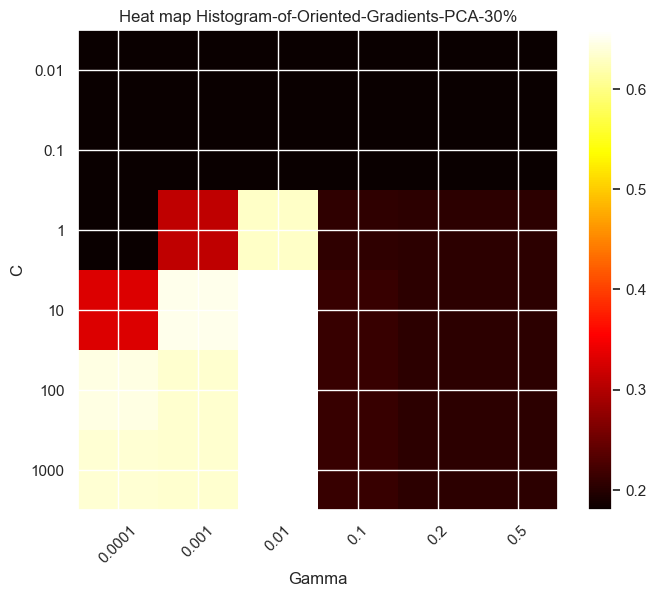

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.01, 'gamma': 0.2, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.01, 'gamma': 0.5, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.1, 'gamma': 0.2, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}
0.180 (+/-0.003) para {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.309 (+/-0.049) para {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.631 (+/-0.064) para {'C': 1, 'gamma': 0.0

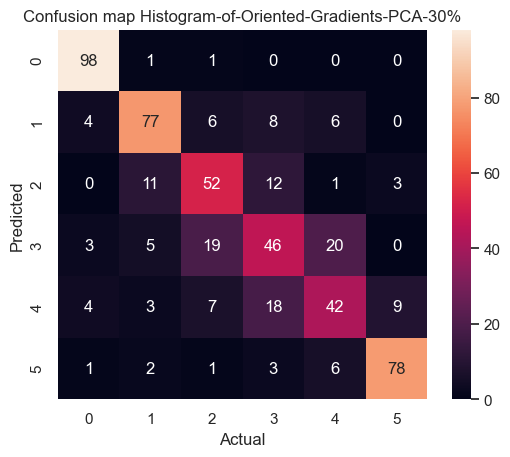

In [23]:
#As the first method of classification we use Support Vector Machine 
def SVM(txt,test_percentage):
    pathsvm = base + "Feature-Extraction/SVM"
    
    if not os.path.exists(pathsvm):
        os.makedirs(pathsvm)
        
    data = pd.read_csv(base + '/Feature-Extraction/'+txt+'.txt',sep=',',header=None)
    
    # we shuffle it for better performance 
    data=shuffle(data, random_state=42)
    
    s=data.shape
    col=[]
    #data.columns = ["a", "b", "c", "etc."]
     
    for x in range(0, s[1]):
        if x==0:
            col.append("NAME")
        elif x ==s[1]-1:
            col.append("TAG")
        else:
            col.append("VALOR-"+str(x))
    
    #se asigna el vector con los nombres de las columnas creado previamente y se las asignamos a la tabla
    data.columns = col
    
    ##print(data.groupby(['TAG'])['TAG'].count())
    vals_to_replace = { '0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                         0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}
    
    data['TAG'] = data['TAG'].map(vals_to_replace)
    
    #print(data.tail())
    
    no_col=['NAME','TAG']
    #obtener todas las columnas
    allValuesName = [x for x in col if x not in no_col]
    #se obtienen solo los coefficientes
    value=data[allValuesName]
    
    tags=data[col[-1]] #columna de tags
    
    data['gender'] = data['NAME'].map(lambda x: 'woman' in x.lower())
    
    # i added a stratify to the train_test_split to make sure that the train and test sets have the same proportion of class labels as the input data
    # its based on gender
    X_train, X_test, Y_train, Y_test = train_test_split(value,tags,test_size=test_percentage,stratify=data['gender'], random_state=42)
    
    
    
    C_range=[0.01, 0.1, 1, 10, 100, 1000]
    gamma_range=[1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5]
    parameters= [
        {
            'kernel': ['rbf'],
            'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
            'C': [0.01, 0.1, 1, 10, 100, 1000]
        }#, 
        #{
        #    'kernel': ['linear'],
        #    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
        #}, 
        #{
        #    'kernel': ['sigmoid'],
        #    'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
        #    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
        #}, 
        #{
        #    'kernel': ['poly'],
        #    'gamma': [1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.5],
        #    'C': [0.01, 0.1, 1, 10, 100, 1000, 10000]
        #}
        
    ]
    # 
    clf =GridSearchCV(svm.SVC(decision_function_shape='ovr'), param_grid=parameters)
    clf.fit(X_train,Y_train)
    clf.best_params_ 
    scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
    print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    fig=plt.title('Heat map '+txt+'-'+str(int(test_percentage*100))+'%')
    fig.get_figure().savefig(base + r'Feature-Extraction/SVM/Heatmap-'+txt+'-'+str(int(test_percentage*100))+'%.jpg')
    plt.show()
    print(clf.best_params_)#mejor parametro
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for m, s, p in zip(means, stds, params):
        print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))
    
    y_pred = clf.predict(X_test)
    
    target_names=["0","1","2","3","4","5"]
    
    table=classification_report(Y_test,y_pred, target_names=target_names)
    table=str(table)
    print(table)
    file = open(base +r"Feature-Extraction/SVM/Reports.txt", "a+")
    file.write(txt+'-'+str(int(test_percentage*100))+'%\n\n')
    file.write(table+'\n')
    mat=confusion_matrix(Y_test, y_pred)
    
    Matrizconf=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
               xticklabels=target_names, yticklabels= target_names )
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    mat=plt.title('Confusion map '+txt+'-'+str(int(test_percentage*100))+'%')
    
    Matrizconf.get_figure().savefig(base + r'Feature-Extraction/SVM/Confusionmap-'+txt+'-'+str(int(test_percentage*100))+'%.png')
    print(Y_train.groupby(Y_train).count())#datos de entrenamiento
    print(Y_test.groupby(Y_test).count(),collections.Counter(y_pred))#datos de testeo
    
    joblib.dump(clf,base +r'Feature-Extraction/SVM/modelo_entrenado-'+txt+'-'+str(int(test_percentage*100))+'%.pkl')
    
    # se llama el modelo
    #clf=joblib.load('modelo_entrenado.pkl')
    # se toma todo el dataset
    print(clf.score(value,tags))
    file.close()
# porcentaje_test=[0.30,0.25,0.20]
# SVM("Elliptic-Fourier",porcentaje_test[1])

SVM("Histogram-of-Oriented-Gradients-PCA" ,0.3)



In [ ]:
#As a second method of classification we use K-Nearest Neighbour Classifier
def KNN(txt,test):
       
    pathknn = base +"Feature-Extraction/KNN"
    if not os.path.exists(pathknn):
        os.makedirs(pathknn)
        
    data = pd.read_csv(base +'Feature-Extraction/'+txt+'.txt',sep=',',header=None)
    data=shuffle(data, random_state=0)
    
    s=data.shape# tamaño de dataframe
    col=[]
    #data.columns = ["a", "b", "c", "etc."]
     
    for x in range(0, s[1]):
        if x==0:
            col.append("NAME")
        elif x ==s[1]-1:
            col.append("TAG")
        else:
            col.append("VALOR-"+str(x))
    
    #se asigna el vector con los nombres de las columnas creado previamente y se las asignamos a la tabla
    data.columns = col
    
    ##print(data.groupby(['TAG'])['TAG'].count())
    vals_to_replace = { '0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                         0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}
    
    data['TAG'] = data['TAG'].map(vals_to_replace)
    
    #print(data.tail())
    
    no_col=['NAME','TAG']
    #obtener todas las columnas
    Name_value = [x for x in col if x not in no_col]
    #se obtienen solo los coefficientes
    value=data[Name_value]
    
    tags=data[col[-1]] #columna de tags
    
    X_train, X_test, Y_train, Y_test = train_test_split(value,tags,test_size=test, random_state=0)
    C_range=[1,2,5,25,50,100]
    gamma_range=[1,2,5,10]
    parameters= [
        {
            'n_neighbors': [1,2,5,25,50,100],
            'metric': ['minkowski'],
            'p': [1,2,5,10]
        }        
    ]
    
    clf = GridSearchCV(KNeighborsClassifier(), param_grid=parameters, cv=5)
    clf.fit(X_train,Y_train)
    
    scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
    print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('P')
    plt.ylabel('N neighbors')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    fig=plt.title('Heat map '+txt+'-'+str(int(test*100))+'%')
    fig.get_figure().savefig(base + 'Feature-Extraction/KNN/Heatmap-'+txt+'-'+str(int(test*100))+'%.jpg')
    plt.show()
    print(clf.best_params_)#mejor parametro
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for m, s, p in zip(means, stds, params):
        print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))
    
    y_pred = clf.predict(X_test)
    
    target_names=["0","1","2","3","4","5"]
    
    table=classification_report(Y_test,y_pred, target_names=target_names)
    table=str(table)
    print(table)
    file = open(base +"Feature-Extraction/KNN/Reports.txt", "a+")
    file.write(txt+'-'+str(int(test*100))+'%\n\n')
    file.write(table+'\n')
    mat=confusion_matrix(Y_test, y_pred)
    
    Matrizconf=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
               xticklabels=target_names, yticklabels= target_names )
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    mat=plt.title('Confusion map '+txt+'-'+str(int(test*100))+'%')
    
    Matrizconf.get_figure().savefig(base + 'Feature-Extraction/KNN/Confusionmap-'+txt+'-'+str(int(test*100))+'%.png')
    print(Y_train.groupby(Y_train).count())#datos de entrenamiento
    print(Y_test.groupby(Y_test).count(),collections.Counter(y_pred))#datos de testeo
    
    joblib.dump(clf,base + 'Feature-Extraction/KNN/modelo_entrenado-'+txt+'-'+str(int(test*100))+'%.pkl')
    
    # se llama el modelo
    #clf=joblib.load('modelo_entrenado.pkl')
    # se toma todo el dataset
    print(clf.score(value,tags))
    file.close()


# porcentaje_test=[0.30,0.25,0.20]
# KNN("Elliptic-Fourier",porcentaje_test[1])

In [ ]:
#As Tecer method of classification we use Neural Networks
def NN(txt,test):
    
    pathnn = base + r"Feature-Extraction/NN"
    if not os.path.exists(pathnn):
        os.makedirs(pathnn)
        
    data = pd.read_csv(base +'Feature-Extraction/'+txt+'.txt',sep=',',header=None)
    data=shuffle(data, random_state=0)
    
    s=data.shape# tamaño de dataframe
    col=[]
    #data.columns = ["a", "b", "c", "etc."]
     
    for x in range(0, s[1]):
        if x==0:
            col.append("NAME")
        elif x ==s[1]-1:
            col.append("TAG")
        else:
            col.append("VALOR-"+str(x))
    
    #se asigna el vector con los nombres de las columnas creado previamente y se las asignamos a la tabla
    data.columns = col
    
    ##print(data.groupby(['TAG'])['TAG'].count())
    vals_to_replace = { '0':'0', '1':'1', '2':'2', '3':'3', '4':'4', '5':'5',
                         0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5'}
    
    data['TAG'] = data['TAG'].map(vals_to_replace)
    
    #print(data.tail())
    
    no_col=['NAME','TAG']
    #obtener todas las columnas
    Name_value = [x for x in col if x not in no_col]
    #se obtienen solo los coefficientes
    value=data[Name_value]
    
    tags=data[col[-1]] #columna de tags
    
    X_train, X_test, Y_train, Y_test = train_test_split(value,tags,test_size=test, random_state=0)
    C_range=[1,0.1,0.01,0.001,0.0001,0]
    gamma_range=[(100,1), (100,2), (100,3)]
    parameters= [
        {
            'solver':['lbfgs'], 
            'alpha':[1,0.1,0.01,0.001,0.0001,0],
            'hidden_layer_sizes':[(100,1), (100,2), (100,3)]
        }
    ]
        
    clf =GridSearchCV(MLPClassifier(), param_grid=parameters, cv=5)
    clf.fit(X_train,Y_train)
    
    scores = clf.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range))
    print("The best parameters are %s with a score of %0.2f" % (clf.best_params_, clf.best_score_))
    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
    plt.xlabel('hidden_layer_sizes')
    plt.ylabel('Alpha')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    fig=plt.title('Validation accuracy')
    fig.get_figure().savefig(base + r'Feature-Extraction/NN/Heatmap-'+txt+'-'+str(int(test*100))+'%.jpg')
    plt.show()
    print(clf.best_params_)#mejor parametro
    
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for m, s, p in zip(means, stds, params):
        print("%0.3f (+/-%0.3f) para %r"%(m, 2*s, p))
    
    y_pred = clf.predict(X_test)
    
    target_names=["0","1","2","3","4","5"]
    
    table=classification_report(Y_test,y_pred, target_names=target_names)
    table=str(table)
    print(table)
    file = open(base + r"Feature-Extraction/NN/Reports.txt", "a+")
    file.write(txt+'-'+str(int(test*100))+'%\n\n')
    file.write(table+'\n')
    mat=confusion_matrix(Y_test, y_pred)
    
    Matrizconf=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
               xticklabels=target_names, yticklabels= target_names )
    
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    mat=plt.title('Confusion map '+txt+'-'+str(int(test*100))+'%')
    
    Matrizconf.get_figure().savefig(base + r'Feature-Extraction/NN/Confusionmap-'+txt+'-'+str(int(test*100))+'%.png')
    print(Y_train.groupby(Y_train).count())#datos de entrenamiento
    print(Y_test.groupby(Y_test).count(),collections.Counter(y_pred))#datos de testeo
    
    joblib.dump(clf,base + r'Feature-Extraction/NN/modelo_entrenado-'+txt+'-'+str(int(test*100))+'%.pkl')
    
    # se llama el modelo
    #clf=joblib.load('modelo_entrenado.pkl')
    # se toma todo el dataset
    print(clf.score(value,tags))
    file.close()

# porcentaje_test=[0.30,0.25,0.20]
# NN("Elliptic-Fourier",porcentaje_test[1])


In [ ]:
if __name__ == "__main__":
    #Preprocessing
    # ImageSegmentation()
    #Feature Extraction
    # EllipticFourier()
    # HOG()
    # HU()
    # GM()
    # CoF()
    porcentaje_test=[0.30,0.25,0.20]
    #Classification
    for j in tqdm(range(len(porcentaje_test))):
        #Support Vector Machine
        # SVM("Elliptic-Fourier",porcentaje_test[j])
        # SVM("Histogram-of-Oriented-Gradients-PCA",porcentaje_test[j])
        # SVM("Hu-Moments-Nmz",porcentaje_test[j])
        # SVM("Geometric",porcentaje_test[j])
        SVM("CoF",porcentaje_test[j])
        # SVM("HOG_EF",porcentaje_test[j])
        #K-Nearest Neighbors
        # KNN("Elliptic-Fourier",porcentaje_test[j])
        # KNN("Histogram-of-Oriented-Gradients-PCA",porcentaje_test[j])
        # KNN("Hu-Moments-Nmz",porcentaje_test[j])
        # KNN("Geometric",porcentaje_test[j])
        KNN("CoF",porcentaje_test[j])
        # KNN("HOG_EF",porcentaje_test[j])
        #Neural Network
        # NN("Elliptic-Fourier",porcentaje_test[j])
        # NN("Histogram-of-Oriented-Gradients-PCA",porcentaje_test[j])
        # NN("Hu-Moments-Nmz",porcentaje_test[j])
        # NN("Geometric",porcentaje_test[j])
        NN("CoF",porcentaje_test[j])
        # NN("HOG_EF",porcentaje_test[j])

In [ ]:
# !rm -rf /content/kaggle/Feature-Extraction\KNN

## Conclusion
1. With this method for the recognition of Colombian sign language can be tried with new signs extending the dataset, also is open research because it can be tested with new methods of preprocessing, extraction of characteristics, classification being able to get to raise even more the percentages of prediction.

2. According to the methods used for the extraction of characteristics, based on table 2, the characteristics of the gradient-oriented histograms (HOG) are the ones that obtained the highest percentage.

3. When performing the main component analysis process, it is concluded that this process will reduce the percentage of the model's performance measure slightly.

4. The geometric characteristics did not give a good result because the images contain similar characteristics such as the area or contour, this results in the model being able to predict the signs in a bad way.